In [1]:
# Imports 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext
from keras.models import model_from_json
import glob
import matplotlib.gridspec as gridspec

2022-05-10 14:03:04.085710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaid/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-10 14:03:04.085733: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Part 1: Extract License Plate from Car Image

In [2]:
# Functions Definition

def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img
    
def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

In [3]:
# Load WPOD-NET

wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

2022-05-10 14:03:05.730605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 14:03:05.731118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaid/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-10 14:03:05.731333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaid/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-10 14:03:05.731399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublas

Loading model successfully...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LPlates/usa_car1.png


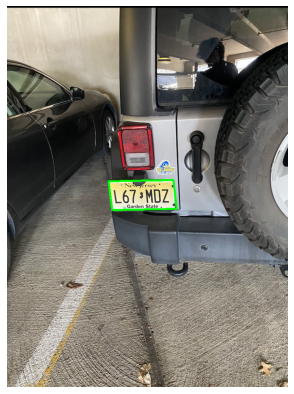

In [4]:
# Extract LP using WPOD-NET

image_own = glob.glob("LPlates/*.png")
digit_w, digit_h = 50, 50

test_image = image_own[0]
LpImg, cor = get_plate(test_image)

print(test_image)
plt.figure(figsize=(7,7))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))
plt.show()

# Part 2: Extract Digits from License Plate Image

In [5]:
# Functions Definition

def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

def extractDigits(plateImg, digit_w, digit_h):
    plateImg = cv2.convertScaleAbs(plateImg[0], alpha=(255.0))
    gray = cv2.cvtColor(plateImg, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 20, 20, 20)
    edged = cv2.Canny(gray, 200, 200) 
    edged = cv2.bilateralFilter(edged, 20, 40, 20) 

    thresh = cv2.dilate(edged, None, iterations=1)
    # thresh = cv2.erode(thresh, None, iterations=1)

    binary = 255 - cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    cont, _  = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    test_roi = plateImg.copy()
    crop_characters = []
    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        if (h/plateImg.shape[0])>=0.4 and (w/plateImg.shape[1])<0.5:
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            curr_num = binary[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            # crop_characters.append(curr_num)
            if curr_num[0][0] == 0:
                curr_num = 255 - curr_num
            crop_characters.append(255 - cv2.copyMakeBorder(curr_num, 15, 15, left=15, right=15, borderType=cv2.BORDER_CONSTANT,value=255))

    return crop_characters, test_roi

def printChars(crop_characters):
    fig = plt.figure(figsize=(14,4))
    grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)
    for i in range(len(crop_characters)):
        fig.add_subplot(grid[i])
        plt.axis(False)
        plt.imshow(crop_characters[i],cmap="Greys")

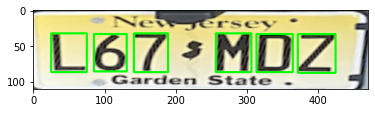

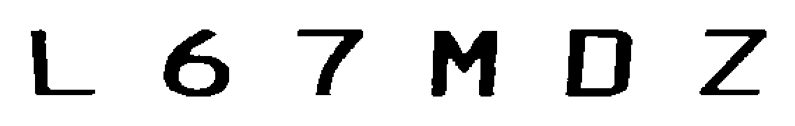

In [6]:
# Extract digits with image transformations and contours extraction

crop_characters, test_roi = extractDigits(LpImg, digit_w, digit_h)

plt.imshow(test_roi)
plt.show()

printChars(crop_characters)

# Part 3: Classify Digits

In [7]:
# Model Definition (OUR MODEL)

import torch
import torch.nn as nn
import pickle 

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        ### Convolutional section
        self.le_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 

            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),

            nn.Linear(12800, 36),

            nn.Softmax(1)
        )

    def forward(self, x):
        output = self.le_cnn(x)
             
        return output

In [8]:
# Weights and labels Import 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn = CNN()
cnn.load_state_dict(torch.load('DigitClassifier0.002020202111452818'))
cnn.to(device)

cnn.eval()

with open('./labelEncoder.obj', 'rb') as file_lb:
    lb = pickle.load(file_lb)

In [9]:
# Function Definition

def classifyDigit(observation, lb):
    obs = torch.from_numpy(observation)
    obs = obs.to(device, dtype=torch.float)

    cnn.eval()
    with torch.no_grad():
        predLabel  = cnn(obs)
    predLabel = np.argmax(predLabel.cpu().numpy(),axis=1)

    return lb.inverse_transform(predLabel)

In [10]:
# Digits Classification

digits = np.array(crop_characters)/255
digits = np.expand_dims(np.array(digits),1)

# plt.imshow(digits[0,0,...])
# plt.colorbar()
# plt.show()

lpIdentified = ''.join(classifyDigit(digits, lb))
print('Identified License Plate: {0}'.format(lpIdentified))

Identified License Plate: L67MDZ
